In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import os
import json
import zipfile
import networkx as nx
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.figure_factory as ff

from tqdm import tqdm
from matplotlib import rc
from matplotlib import colormaps
from collections import defaultdict

In [4]:
df = pd.read_csv("../data/cl_papers.csv", sep=",", index_col=0)
df.head()

,id,title,area,source,year,doi,abstract,semantic_scholar_id
0,main.1004,AnswerFact: Fact Checking in Product Question ...,Question Answering,EMNLP,2020,10.18653/v1/2020.emnlp-main.188,Product-related question answering platforms n...,4c61df1b4b9a164fec1a34587b4fffae029cd18c
1,main.1006,Knowledge-Grounded Dialogue Generation with Pr...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.272,We study knowledge-grounded dialogue generatio...,3447a432f724aa36595643446acda5b78943db19
2,main.1009,BiST: Bi-directional Spatio-Temporal Reasoning...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.145,Video-grounded dialogues are very challenging ...,f4a2acfeb1705df3f430cc53ace26e1dbbbcbd16
3,main.1010,A Knowledge-Aware Sequence-to-Tree Network for...,NLP Applications,EMNLP,2020,10.18653/v1/2020.emnlp-main.579,With the advancements in natural language proc...,24ed85ad966823868c1694a19385d01c6ad71008
4,main.1011,Knowledge Association with Hyperbolic Knowledg...,Information Extraction,EMNLP,2020,10.18653/v1/2020.emnlp-main.460,Capturing associations for knowledge graphs (K...,3d61a28b9429fc8f7047fc379a0134a3765edbcb


In [5]:
raw_tracks = set(df['area'])

raw_tracks

{'Applications',
 'Area A (Information Extraction and Question Answering) [LONG]',
 'Area A from Area F (Discourse, Dialog, Summarization, Generation, Multimodal NLP) [LONG]',
 'Area B (Text Mining and Information Retrieval) [LONG]',
 'Area C (Social Media, Computational Social Science, Sentiment,  Opinion) [LONG]',
 'Area D (Morphology, Syntax, Chunking, Psycholinguistics) [LONG]',
 'Area E (Semantics) [LONG]',
 'Area F (Discourse, Dialog, Summarization, Generation, Multimodal NLP) [LONG]',
 'Area G (Machine Translation and Multilinguality) [LONG]',
 'Area H (Machine Learning) [LONG]',
 'Area H or D',
 'Argument Mining',
 'Best Paper Session',
 'Bias in Language Processing',
 'Cognitive Modeling and Psycholinguistics',
 'Commonsense Reasoning',
 'Computational Social Science and Cultural Analytics',
 'Computational Social Science and Social Media',
 'Dialog System',
 'Dialog System, Discourse',
 'Dialog and Interactive Systems',
 'Dialog and Interactive Systems, Machine Translation an

In [10]:
analysis_or_interpretability_tracks = list(filter(lambda x: 'interpretability' in x.lower() or 'analysis of language models' in x.lower(), raw_tracks))
print('interp & analysis tracks')
print(analysis_or_interpretability_tracks)
print()

syntax_tracks = list(filter(lambda x: 'syntax' in x.lower(), raw_tracks))
print('syntax tracks')
print(syntax_tracks)
print()

mt_tracks = list(filter(lambda x: 'translation' in x.lower(), raw_tracks))
print('MT tracks')
print(mt_tracks)
print()

grounding_tracks = list(filter(lambda x: 'grounding' in x.lower(), raw_tracks))
print('grounding tracks')
print(grounding_tracks)
print()

semantics_tracks = list(filter(lambda x: 'semantics' in x.lower(), raw_tracks))
print('semantics tracks')
print(semantics_tracks)
print()

evaluation_tracks = list(filter(lambda x: 'evaluation' in x.lower(), raw_tracks))
print('evaluation tracks')
print(evaluation_tracks)
print()

info_extraction_tracks = list(filter(lambda x: 'extraction' in x.lower() or 'retrieval' in x.lower(), raw_tracks))
print('info_extraction tracks')
print(info_extraction_tracks)
print()

qa_tracks = list(filter(lambda x: 'answering' in x.lower(), raw_tracks))
print('qa_tracks')
print(qa_tracks)
print()

dialogue_tracks = list(filter(lambda x: 'dialog' in x.lower(), raw_tracks))
print('dialogue_tracks')
print(dialogue_tracks)
print()

sentiment_analysis_tracks = list(filter(lambda x: 'sentiment analysis' in x.lower(), raw_tracks))
print('sentiment_analysis_tracks')
print(sentiment_analysis_tracks)
print()

applications_tracks = list(filter(lambda x: 'nlp applications' in x.lower(), raw_tracks))
print('applications_tracks')
print(applications_tracks)
print()

ml_tracks = list(filter(lambda x: 'machine learning' in x.lower(), raw_tracks))
print('ml_tracks')
print(ml_tracks)
print()

generation_tracks = list(filter(lambda x: 'generation' in x.lower(), raw_tracks))
print('generation_tracks')
print(generation_tracks)
print()

interp & analysis tracks
['Language Modeling and Analysis of Language Models', 'Interpretability, Interactivity, and Analysis of Models for NLP', 'Interpretability, Interactivity and Analysis of Models for NLP', 'Interpretability and Analysis of Models for NLP']

syntax tracks
['Syntax, Parsing and their Applications', 'Syntax: Tagging, Chunking and Parsing', 'Dialog and Interactive Systems, Machine Translation and Multilinuality, Phonology, Morphology, and Word Segmentation, Speech, Vision, Robotics, Multimodal and Grounding, Tagging, Chunking, Syntax and Parsing', 'Syntax, Parsing, and Linguistic Theories', 'Syntax: Tagging, Chunking, and Parsing', 'Machine Translation and Mulitilinguality, Phonology, Morphology and Word Segmentation, Tagging, Chunking, Syntax and Parsing', 'Tagging, Chunking, Syntax and Parsing', 'Area D (Morphology, Syntax, Chunking, Psycholinguistics) [LONG]']

MT tracks
['Machine Translation', 'Dialog and Interactive Systems, Machine Translation and Multilinualit

In [11]:
def raw_track_to_track(raw_track):
    if raw_track in analysis_or_interpretability_tracks:
        return 'Interpretability and Analysis'
    if raw_track in syntax_tracks:
        return 'Syntax'
    if raw_track in mt_tracks:
        return 'Machine Translation'
    if raw_track in grounding_tracks:
        return 'Grounding'
    if raw_track in semantics_tracks:
        return 'Semantics'
    if raw_track in evaluation_tracks:
        return 'Evaluation'
    if raw_track in info_extraction_tracks:
        return 'Information Extraction/Retrieval'
    if raw_track in qa_tracks:
        return 'Question Answering'
    if raw_track in dialogue_tracks:
        return 'Dialogue'
    if raw_track in sentiment_analysis_tracks:
        return 'Sentiment Analysis'
    if raw_track in applications_tracks:
        return 'Applications'
    if raw_track in ml_tracks:
        return 'Machine Learning'
    if raw_track in generation_tracks:
        return 'Generation'
    return None


df['track'] = df['area'].apply(raw_track_to_track)
df

,id,title,area,source,year,doi,abstract,semantic_scholar_id,track
0,main.1004,AnswerFact: Fact Checking in Product Question ...,Question Answering,EMNLP,2020,10.18653/v1/2020.emnlp-main.188,Product-related question answering platforms n...,4c61df1b4b9a164fec1a34587b4fffae029cd18c,Question Answering
1,main.1006,Knowledge-Grounded Dialogue Generation with Pr...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.272,We study knowledge-grounded dialogue generatio...,3447a432f724aa36595643446acda5b78943db19,Dialogue
2,main.1009,BiST: Bi-directional Spatio-Temporal Reasoning...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.145,Video-grounded dialogues are very challenging ...,f4a2acfeb1705df3f430cc53ace26e1dbbbcbd16,Dialogue
3,main.1010,A Knowledge-Aware Sequence-to-Tree Network for...,NLP Applications,EMNLP,2020,10.18653/v1/2020.emnlp-main.579,With the advancements in natural language proc...,24ed85ad966823868c1694a19385d01c6ad71008,Applications
4,main.1011,Knowledge Association with Hyperbolic Knowledg...,Information Extraction,EMNLP,2020,10.18653/v1/2020.emnlp-main.460,Capturing associations for knowledge graphs (K...,3d61a28b9429fc8f7047fc379a0134a3765edbcb,Information Extraction/Retrieval
...,...,...,...,...,...,...,...,...,...
9250,T4773,Rank-Aware Negative Training for Semi-Supervis...,Machine Learning for NLP,ACL,2023,10.1162/tacl_a_00574,Abstract Semi-supervised text classification-b...,79a502caa0b12573f56a7e8948459722aa891479,Machine Learning
9251,T4777,Transparency Helps Reveal When Language Models...,"Linguistic Theories, Cognitive Modeling, and P...",ACL,2023,10.1162/tacl_a_00565,Many current NLP systems are built from langua...,eee70790ced38b0fcf50351dbb3dcbdb582467e8,None
9252,T4803,Design Choices for Crowdsourcing Implicit Disc...,Discourse and Pragmatics,ACL,2023,10.1162/tacl_a_00586,Abstract Disagreement in natural language anno...,bf65a1b637e0f253abb8402fc9d0ab80db79aa92,None
9253,T4929,Time-and-Space-Efficient Weighted Deduction,"Semantics: Sentence-level Semantics, Textual I...",ACL,2023,10.1162/tacl_a_00588,Abstract Many NLP algorithms have been describ...,f1803d124e5af7263ce656f7ccf3219eacc62b1c,Semantics


In [12]:

post_2020_df = df[df['year'] >= 2020].copy()
post_2020_df.head()

,id,title,area,source,year,doi,abstract,semantic_scholar_id,track
0,main.1004,AnswerFact: Fact Checking in Product Question ...,Question Answering,EMNLP,2020,10.18653/v1/2020.emnlp-main.188,Product-related question answering platforms n...,4c61df1b4b9a164fec1a34587b4fffae029cd18c,Question Answering
1,main.1006,Knowledge-Grounded Dialogue Generation with Pr...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.272,We study knowledge-grounded dialogue generatio...,3447a432f724aa36595643446acda5b78943db19,Dialogue
2,main.1009,BiST: Bi-directional Spatio-Temporal Reasoning...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.145,Video-grounded dialogues are very challenging ...,f4a2acfeb1705df3f430cc53ace26e1dbbbcbd16,Dialogue
3,main.1010,A Knowledge-Aware Sequence-to-Tree Network for...,NLP Applications,EMNLP,2020,10.18653/v1/2020.emnlp-main.579,With the advancements in natural language proc...,24ed85ad966823868c1694a19385d01c6ad71008,Applications
4,main.1011,Knowledge Association with Hyperbolic Knowledg...,Information Extraction,EMNLP,2020,10.18653/v1/2020.emnlp-main.460,Capturing associations for knowledge graphs (K...,3d61a28b9429fc8f7047fc379a0134a3765edbcb,Information Extraction/Retrieval


In [13]:
track_styles = {
    'Dialogue': {'color': '#66c2a5', 'marker': 'circle'},
    'Evaluation': {'color': '#e78ac3', 'marker': 'square'},
    'Grounding': {'color': '#fc8d62', 'marker': 'diamond'},
    'Information Extraction/Retrieval': {'color': '#8da0cb', 'marker': 'cross'},
    'Interpretability and Analysis': {'color': '#FF0000', 'marker': 'x'},
    'Machine Translation': {'color': '#a6d854', 'marker': 'triangle-up'},
    'Question Answering': {'color': '#ffd92f', 'marker': 'triangle-down'},
    'Semantics': {'color': '#e5c494', 'marker': 'star'},
    'Syntax': {'color': '#b3b3b3', 'marker': 'hexagon'},
    'Applications': {'color': '#b15928', 'marker': 'pentagon'},
    'Machine Learning': {'color': '#980e59', 'marker': 'triangle-left'},
    'Sentiment Analysis': {'color': '#ff7f00', 'marker': 'circle-x-open'},
    'Generation': {'color': '#6a3d9a', 'marker': 'triangle-nw'},
}


In [14]:
all_tracks = sorted(set(post_2020_df['track']), key=lambda x: (x is None, x))
colors = plt.cm.get_cmap('Set2', len(all_tracks))
color_mapping = {track: colors(i) for i, track in enumerate(all_tracks)}
color_mapping['Evaluation'] = color_mapping['Interpretability and Analysis']
color_mapping['Interpretability and Analysis'] =  '#FF0000'

/var/folders/jd/xcxq41xd1bx5jvgpwp14tr940000gn/T/ipykernel_11156/3665633210.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(all_tracks))


In [15]:
color_mapping

{'Applications': (0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
 'Dialogue': (0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
 'Evaluation': (0.9058823529411765,
  0.5411764705882353,
  0.7647058823529411,
  1.0),
 'Generation': (0.9882352941176471,
  0.5529411764705883,
  0.3843137254901961,
  1.0),
 'Grounding': (0.5529411764705883, 0.6274509803921569, 0.796078431372549, 1.0),
 'Information Extraction/Retrieval': (0.9058823529411765,
  0.5411764705882353,
  0.7647058823529411,
  1.0),
 'Interpretability and Analysis': '#FF0000',
 'Machine Learning': (0.6509803921568628,
  0.8470588235294118,
  0.32941176470588235,
  1.0),
 'Machine Translation': (0.6509803921568628,
  0.8470588235294118,
  0.32941176470588235,
  1.0),
 'Question Answering': (1.0, 0.8509803921568627, 0.1843137254901961, 1.0),
 'Semantics': (0.8980392156862745,
  0.7686274509803922,
  0.5803921568627451,
  1.0),
 'Sentiment Analysis': (0.8980392156862745,
  0.7686274509803922,
  0.5803921568627451,
  1.0),
 'Sy

In [16]:
title_options = {'pad': 15, 'fontsize': 15, 'fontweight': 'bold'}
axis_options = {'fontsize': 14, 'font': 'Arial'}

In [122]:
def track_to_pretty_name(track):
    if track == 'Interpretability and Analysis':
        return 'Interpretability and <br>Analysis'
    elif track == 'Information Extraction/Retrieval':
        return 'Information <br>Extraction/Retrieval'
    
    return track

### Number of papers in EMNLP/ACL per year by track

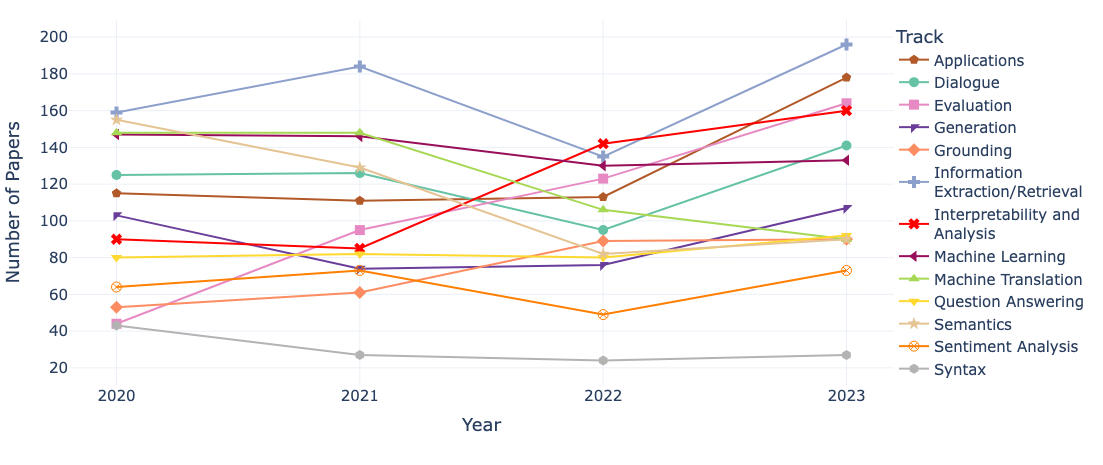

In [125]:
count_data = post_2020_df.groupby('year')['track'].value_counts().unstack().fillna(0)
tracks = count_data.columns
fig = go.Figure()

for track in tracks:
    style = track_styles.get(track, {})
    fig.add_trace(go.Scatter(
        x=count_data.index, 
        y=count_data[track], 
        mode='lines+markers',
        name=track_to_pretty_name(track),
        line=dict(color=style['color']),
        marker=dict(symbol=style['marker'], size=10)
    ))


fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Track',
    legend=dict(
        x=1,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.1)'
    ),
    xaxis=dict(tickmode='array', tickvals=count_data.index, type='category'),
    template='plotly_white',
    width=630,
    height=465,
    margin=dict(l=20, t=20),
    font=dict(size=15)
)

fig.show()


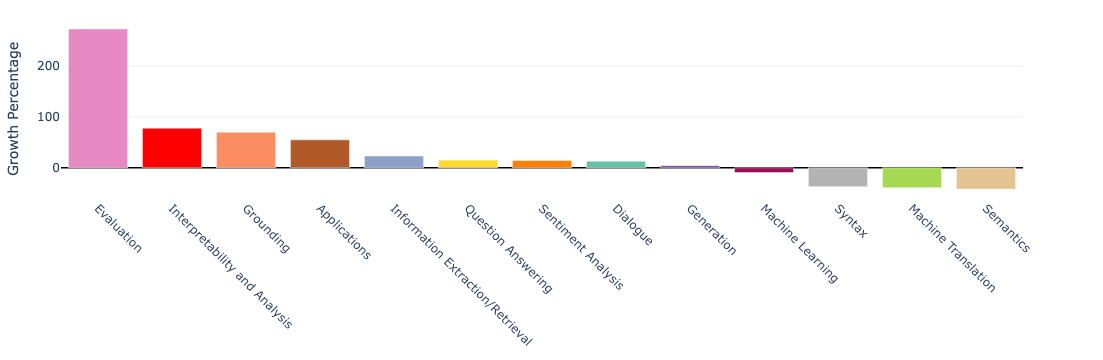

In [119]:
data_2020 = count_data.loc[2020]
data_2023 = count_data.loc[2023]
growth_percentage = ((data_2023 - data_2020) / data_2020) * 100

sorted_growth = growth_percentage.sort_values(ascending=False)

fig = go.Figure()

for track in sorted_growth.index:
    fig.add_trace(go.Bar(
        x=[track],
        y=[sorted_growth[track]],
        name=track,
        marker_color=track_styles[track]['color']
    ))

fig.update_layout(
    yaxis_title='Growth Percentage',
    xaxis=dict(tickangle=45),
    yaxis=dict(zeroline=True, zerolinewidth=1.5, zerolinecolor='black'),
    template='plotly_white',
    showlegend=False,
    margin=dict(l=20, t=20),
)

fig.show()


# Citation data by track

In [23]:
from utils import bulk_get_paper_details

post_2020_df = post_2020_df[~pd.isna(post_2020_df['semantic_scholar_id'])]

semantic_scholar_papers = bulk_get_paper_details(list(post_2020_df['semantic_scholar_id']))

Fetching papers: 14it [00:15,  1.09s/it]


In [24]:
# these papers cannot be found in the semantic scholar API,
# so we can gather this info manually from google scholar
doi_to_n_citations = {
    '10.18653/v1/2021.emnlp-main.582': 14,
    '10.48550/arXiv.2306.09802': 2,
    '10.18653/v1/2023.acl-long.835': 6,
    '10.18653/v1/2023.acl-long.725': 10,
    '10.18653/v1/2021.acl-long.148': 62,
    '10.18653/v1/2022.emnlp-main.650': 27,
    '10.18653/v1/2022.emnlp-main.674': 17,
    '10.18653/v1/2023.emnlp-main.385': 162,
    '10.18653/v1/2023.emnlp-main.616': 9
}



n_citations = []
for paper, doi in zip(semantic_scholar_papers, list(post_2020_df['doi'])):
    if paper is None:
        n_citations.append(doi_to_n_citations[doi])
    else:
        n_citations.append(paper.citation_count)
        
post_2020_df.loc[:, 'citation_count'] = n_citations

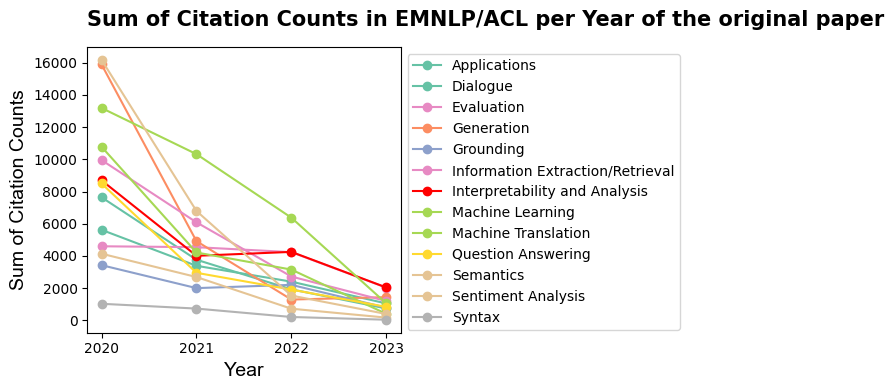

In [25]:
summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].sum().unstack().fillna(0)
tracks = summed_data.columns
fig, ax = plt.subplots(figsize=(7, 4))

for track in tracks:
    ax.plot(summed_data.index, summed_data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Sum of Citation Counts', **axis_options)
ax.set_title('Sum of Citation Counts in EMNLP/ACL per Year of the original paper', loc='left', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


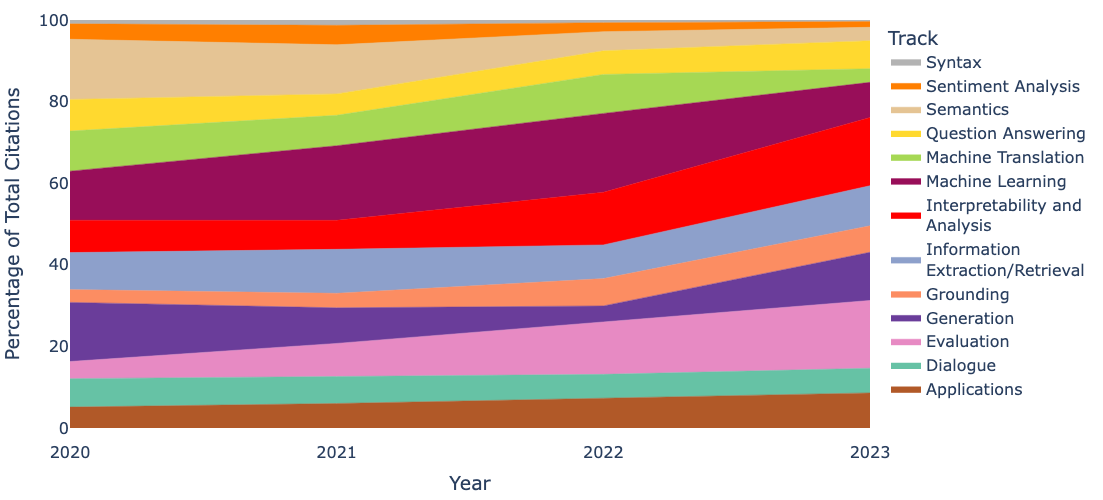

In [126]:
# of course, the older papers are more cited because they have been around longer.
# the interesting thing is that 2023 interpretability papers are the most cited (with evaluation)
# despite not being the track with the most submissions

# the distribution of citations to ACL/EMNLP by track over the years may be more fair

summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].sum().unstack().fillna(0)
percentage_data = summed_data.div(summed_data.sum(axis=1), axis=0) * 100

tracks = percentage_data.columns
fig = go.Figure()

for track in tracks:
    fig.add_trace(go.Scatter(
        x=percentage_data.index, 
        y=percentage_data[track], 
        mode='lines',
        name=track_to_pretty_name(track),
        line_color=track_styles[track]['color'],
        stackgroup='one', 
        line=dict(width=0.5),
        fill='tonexty',
        fillcolor=track_styles[track]['color'],
    ))

fig.update_layout(
    xaxis=dict(title='Year',tickvals=percentage_data.index, tickprefix='<br>', ticks="outside", tickcolor="white", ticklen=10),
    yaxis=dict(title='Percentage of Total Citations', range=[0, 100]),
    legend=dict(title='Track', x=1.02, y=1, bgcolor='rgba(255, 255, 255, 0.5)', bordercolor='rgba(0, 0, 0, 0.1)'),
     margin=dict(l=20, t=20, r=20, b=10),
    hovermode='x unified',
    width=700,
    height=500,
        font=dict(
        size=16,
    )
)

fig.show()

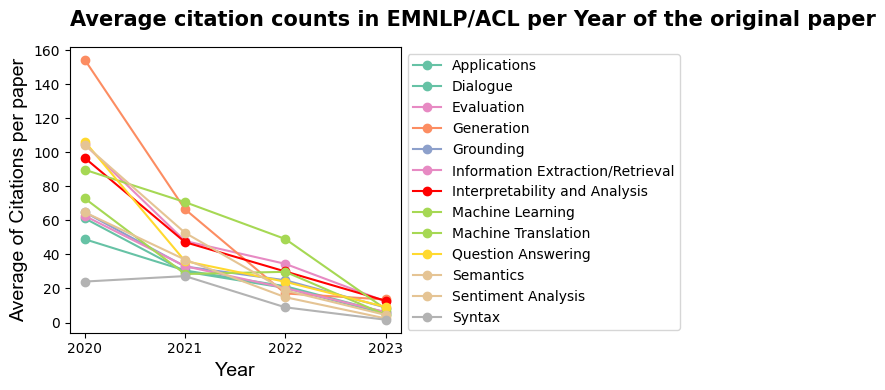

In [128]:
summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].mean().unstack().fillna(0)
tracks = summed_data.columns
fig, ax = plt.subplots(figsize=(7, 4))

for track in tracks:
    ax.plot(summed_data.index, summed_data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Average of Citations per paper', **axis_options)
ax.set_title('Average citation counts in EMNLP/ACL per Year of the original paper', loc='left', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


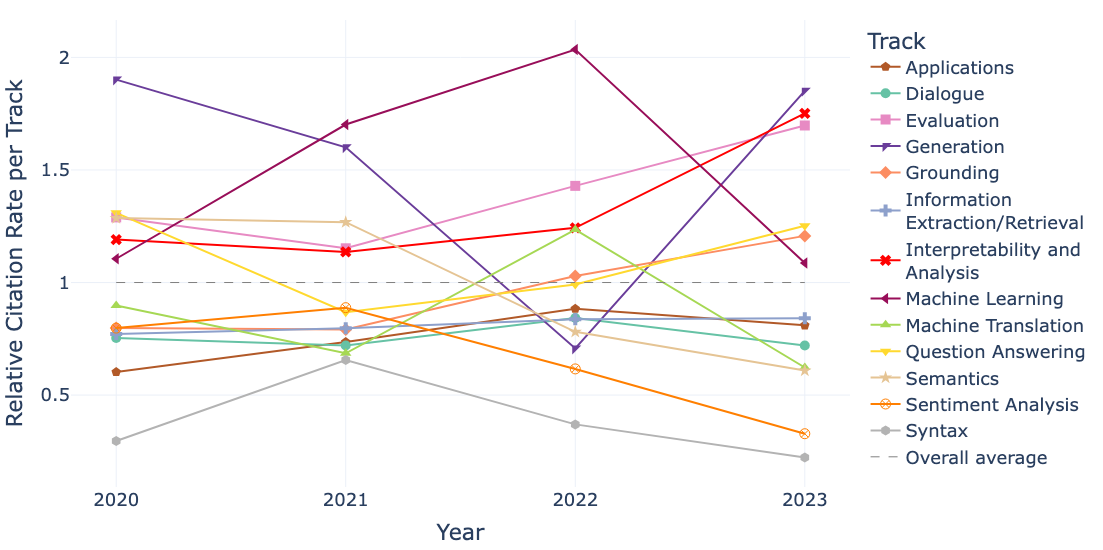

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].mean().unstack().fillna(0)
overall_avg_citations = summed_data.mean(axis=1)

normalized_data = summed_data.div(overall_avg_citations, axis=0)

tracks = normalized_data.columns
fig = go.Figure()

for track in tracks:
    fig.add_trace(go.Scatter(
        x=normalized_data.index,
        y=normalized_data[track],
        mode='lines+markers',
        name=track_to_pretty_name(track),
        line=dict(color=track_styles[track]['color']),  # Using the color mapping defined
        marker=dict(symbol=track_styles[track]['marker'], size=10)
    ))

fig.add_trace(go.Scatter(
    x=normalized_data.index,
    y=[1]*len(normalized_data.index),
    mode='lines',
    name='Overall average',
    line=dict(color='gray', dash='dash', width=1)
))
fig.update_layout(
    width=900,
    height=550,
    xaxis=dict(
        title='Year',
        type='category',
        tickmode='array',
        tickvals=normalized_data.index,
        ticktext=[str(year) for year in normalized_data.index],
    ),
    yaxis=dict(
        title='Relative Citation Rate per Track'
    ),
    legend=dict(
        title='Track',
        bgcolor='rgba(255, 255, 255, 0.8)'
    ),
    font=dict(
        size=18,
    ),
    margin=dict(l=20, t=20, r=20, b=10),
     template='plotly_white',
)

fig.show()

In [132]:
# from here onwards we use the citation graph

json_path = '../citationgraph/graph.json'
zip_path = '../citationgraph/graph.zip'

if not os.path.exists(json_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_path))
    print("ZIP file extracted.")
 
with open(json_path) as f:
    graph_json = json.load(f)
    G = nx.cytoscape_graph(graph_json)

G.number_of_nodes()

185384

In [41]:
G.number_of_edges()

786376

In [42]:
n=0
for node in G.nodes():
    if 'mt_prediction' in G.nodes[node] and G.nodes[node]['mt_prediction'] is not None:
        n+=1
n

176267

In [43]:
tracks = list(set(post_2020_df['track'].dropna()))
years = [2020, 2021, 2022, 2023] # years in which the interp track actually exists

citations_per_year = {track: {year: 0 for year in years} for track in tracks}

for cited_node, citing_node in tqdm(G.edges()):
    citing_year = G.nodes[citing_node]['year']
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track is None:
        continue
    
    if cited_year < 2020:
        # interp started in 2020
        continue
        
    if citing_year is None or citing_year < 2020:
        # we'll ignore these 'impossible' cases
        # most of these are None values anyways
        continue

    if citing_year > 2023:
        # we'll scope it till 2023 only
        continue
    citations_per_year[track][citing_year] += 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 1017323.78it/s]


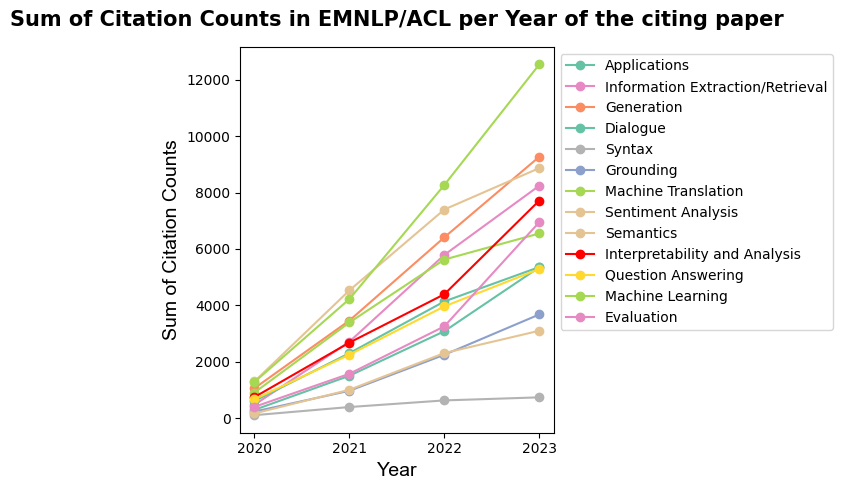

In [44]:
data = pd.DataFrame(citations_per_year, index=years)
fig, ax = plt.subplots(figsize=(7, 5))
for track in data.columns:
    ax.plot(data.index, data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Sum of Citation Counts', **axis_options)
ax.set_title('Sum of Citation Counts in EMNLP/ACL per Year of the citing paper', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

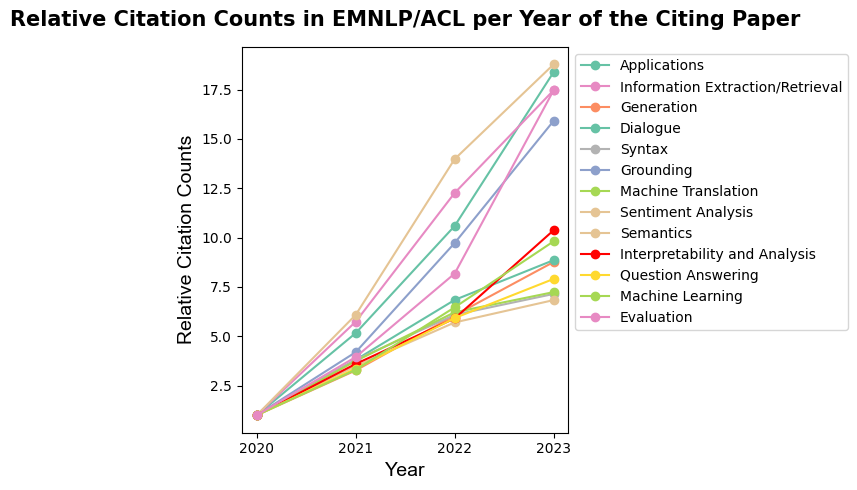

In [45]:
normalized_data = data.divide(data.iloc[0])

fig, ax = plt.subplots(figsize=(7, 5))

for track in normalized_data.columns:
    ax.plot(normalized_data.index, normalized_data[track], marker='o',color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Relative Citation Counts', **axis_options)
ax.set_title('Relative Citation Counts in EMNLP/ACL per Year of the Citing Paper', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

# Most influential papers per track

In [46]:
top_10_per_track = post_2020_df.groupby('track').apply(lambda x: x.nlargest(10, 'citation_count'))
top_10_per_track

/var/folders/jd/xcxq41xd1bx5jvgpwp14tr940000gn/T/ipykernel_11156/1862386437.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



id  \
track                          
Applications 2124        NaN   
             854    main.207   
             442   main.2962   
             4575       1637   
             810    main.204   
...                      ...   
Syntax       1137   main.302   
             3161        NaN   
             3028        NaN   
             4195        642   
             860    main.777   

                                                               title  \
track                                                                  
Applications 2124  CodeT5: Identifier-aware Unified Pre-trained E...   
             854   SPECTER: Document-level Representation Learnin...   
             442        Fact or Fiction: Verifying Scientific Claims   
             4575  UniXcoder: Unified Cross-Modal Pre-training fo...   
             810   DeeBERT: Dynamic Early Exiting for Acceleratin...   
...                                                              ...   
Syntax       1137  Efficient Second-Order TreeCRF for Neural Depe...   
             3161  SpanNER: Named Entity Re-/Recognition as Span ...   
             3028  MulDA: A Multilingual Data Augmentation Framew...   
             4195  MELM: Data Augmentation with Masked Entity Lan...   
             860   SeqVAT: Virtual Adversarial Training for Semi-...   

                                                     area source  year  \
track                                                                    
Applications 2124                        NLP Applications  EMNLP  2021   
             854                         NLP Applications    ACL  2020   
             442                         NLP Applications  EMNLP  2020   
             4575                        NLP Applications    ACL  2022   
             810                         NLP Applications    ACL  2020   
...                                                   ...    ...   ...   
Syntax       1137   Syntax: Tagging, Chunking and Parsing    ACL  2020   
             3161  Syntax: Tagging, Chunking, and Parsing    ACL  2021   
             3028  Syntax: Tagging, Chunking, and Parsing    ACL  2021   
             4195   Syntax: Tagging, Chunking and Parsing    ACL  2022   
             860    Syntax: Tagging, Chunking and Parsing    ACL  2020   

                                               doi  \
track                                                
Applications 2124  10.18653/v1/2021.emnlp-main.685   
             854     10.18653/v1/2020.acl-main.207   
             442   10.18653/v1/2020.emnlp-main.609   
             4575    10.18653/v1/2022.acl-long.499   
             810     10.18653/v1/2020.acl-main.204   
...                                            ...   
Syntax       1137    10.18653/v1/2020.acl-main.302   
             3161    10.18653/v1/2021.acl-long.558   
             3028    10.18653/v1/2021.acl-long.453   
             4195    10.18653/v1/2022.acl-long.160   
             860     10.18653/v1/2020.acl-main.777   

                                                            abstract  \
track                                                                  
Applications 2124  Pre-trained models for Natural Languages (NL) ...   
             854   Representation learning is a critical ingredie...   
             442   We introduce scientific claim verification, a ...   
             4575  Pre-trained models for programming languages h...   
             810   Large-scale pre-trained language models such a...   
...                                                              ...   
Syntax       1137  In the deep learning (DL) era, parsing models ...   
             3161  Recent years have seen the paradigm shift of N...   
             3028  Named Entity Recognition (NER) for low-resourc...   
             4195  Data augmentation is an effective solution to ...   
             860   Virtual adversarial training (VAT) is a powerf...   

                                        semantic_scholar_id         t

In [47]:
i = 1
for _, paper in top_10_per_track[top_10_per_track['track'] == 'Interpretability and Analysis'].iterrows():
    print('% N°', i)
    print('% ' + paper['title'])
    print('% ' + 'doi.org/' + paper['doi'])
    i += 1


% N° 1
% Rethinking the Role of Demonstrations: What Makes In-Context Learning Work?
% doi.org/10.18653/v1/2022.emnlp-main.759
% N° 2
% StereoSet: Measuring stereotypical bias in pretrained language models
% doi.org/10.18653/v1/2021.acl-long.416
% N° 3
% On the Cross-lingual Transferability of Monolingual Representations
% doi.org/10.18653/v1/2020.acl-main.421
% N° 4
% What BERT Is Not: Lessons from a New Suite of Psycholinguistic Diagnostics for Language Models
% doi.org/10.1162/tacl_a_00298
% N° 5
% Quantifying Attention Flow in Transformers
% doi.org/10.18653/v1/2020.acl-main.385
% N° 6
% ERASER: A Benchmark to Evaluate Rationalized NLP Models
% doi.org/10.18653/v1/2020.acl-main.408
% N° 7
% Towards Faithfully Interpretable NLP Systems: How Should We Define and Evaluate Faithfulness?
% doi.org/10.18653/v1/2020.acl-main.386
% N° 8
% CrowS-Pairs: A Challenge Dataset for Measuring Social Biases in Masked Language Models
% doi.org/10.18653/v1/2020.emnlp-main.154
% N° 9
% Transformer Fee

In [48]:
i = 1
for paper in list(top_10_per_track[top_10_per_track['track'] == 'Evaluation']['title']):
    print('N°', i)
    print(paper)
    i += 1

N° 1
Beyond Accuracy: Behavioral Testing of NLP Models with CheckList
N° 2
Adversarial NLI: A New Benchmark for Natural Language Understanding
N° 3
TruthfulQA: Measuring How Models Mimic Human Falsehoods
N° 4
CLIPScore: A Reference-free Evaluation Metric for Image Captioning
N° 5
Cross-Task Generalization via Natural Language Crowdsourcing Instructions
N° 6
SummEval: Re-evaluating Summarization Evaluation
N° 7
Super-NaturalInstructions: Generalization via Declarative Instructions on 1600+ NLP Tasks
N° 8
S2ORC: The Semantic Scholar Open Research Corpus
N° 9
Is ChatGPT a General-Purpose Natural Language Processing Task Solver?
N° 10
MIND: A Large-scale Dataset for News Recommendation


In [49]:
i = 1
for paper in list(top_10_per_track[top_10_per_track['track'] == 'Machine Translation']['title']):
    print('N°', i)
    print(paper)
    i += 1

N° 1
Multilingual Denoising Pre-training for Neural Machine Translation
N° 2
Making Monolingual Sentence Embeddings Multilingual using Knowledge Distillation
N° 3
COMET: A Neural Framework for MT Evaluation
N° 4
Language-agnostic BERT Sentence Embedding
N° 5
MAD-X: An Adapter-Based Framework for Multi-Task Cross-Lingual Transfer
N° 6
The FLORES-101 Evaluation Benchmark for Low-Resource and Multilingual Machine Translation
N° 7
ByT5: Towards a Token-Free Future with Pre-trained Byte-to-Byte Models
N° 8
Improving Massively Multilingual Neural Machine Translation and Zero-Shot Translation
N° 9
XGLUE: A New Benchmark Datasetfor Cross-lingual Pre-training, Understanding and Generation
N° 10
From Zero to Hero: On the Limitations of Zero-Shot Language Transfer with Multilingual Transformers


In [50]:
# Filter out the rows where 'area' is 'Interpretability and Analysis'
df_non_interp = df[df['area'] != 'Interpretability and Analysis']

# Get the top 10 rows by 'citation_count' for each group
# top_citations = df_non_interp.nlargest(10, 'citation_count')


In [51]:
#df_with_ssid = df[~pd.isna(df['semantic_scholar_id'])]
#semantic_scholar_papers = bulk_get_paper_details(list(df_with_ssid['semantic_scholar_id']))



In [52]:
#citations = []
#for paper, (index, row) in zip(semantic_scholar_papers, df_with_ssid.iterrows()):
#    if paper is None:
#        continue
#    citations.append((paper.citation_count, row))

    


# Citations comparing analysis/interpretability vs non

## Is interpretability just citing itself?

In [139]:
from collections import defaultdict

interp_citation_counts = defaultdict(int)
non_interp_citation_counts = defaultdict(int)

for cited_node, citing_node in G.edges():
    # check that the cited node is from the dataset
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue

    # check that it was an interp paper
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Interpretability and Analysis':
        continue

    # check that we have a prediction on whether the citing paper was interp or not
    if 'interpretability_prediction' not in G.nodes[citing_node]:
        continue
    interp = G.nodes[citing_node]['interpretability_prediction']
    if interp is None:
        continue


    citing_year = G.nodes[citing_node]['year']
    if interp is None:
        continue
    if citing_year and 2018 <= citing_year <= 2023:
        if interp:
            interp_citation_counts[citing_year] += 1
        else:
            non_interp_citation_counts[citing_year] += 1

interp_citation_counts, non_interp_citation_counts

(defaultdict(int,
             {2023: 2816,
              2022: 1846,
              2021: 1263,
              2020: 351,
              2018: 1,
              2019: 16}),
 defaultdict(int,
             {2023: 4779,
              2022: 2451,
              2021: 1352,
              2020: 384,
              2019: 10,
              2018: 4}))

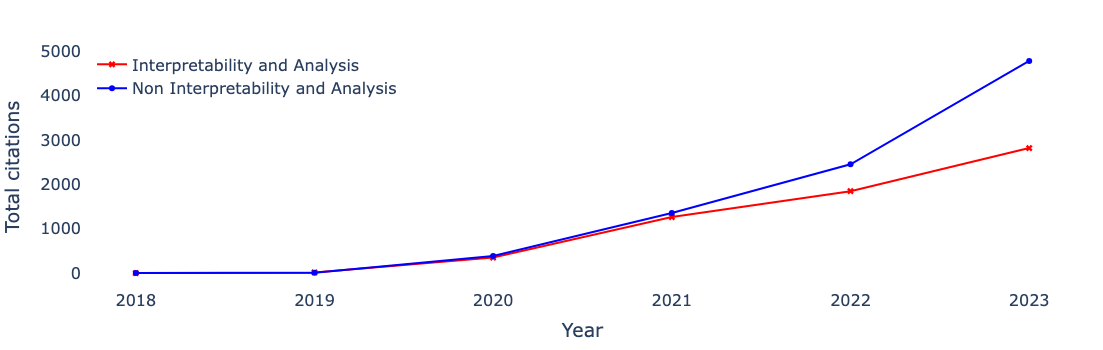

In [145]:
interp = 'Interpretability and Analysis'
years = [2018, 2019, 2020, 2021, 2022, 2023]
data_interp = pd.DataFrame({'Interpretability': [interp_citation_counts.get(year, 0) for year in years]}, index=years)
data_non_interp = pd.DataFrame({'Non-Interpretability': [non_interp_citation_counts.get(year, 0) for year in years]}, index=years)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_interp.index,
    y=data_interp['Interpretability'],
    mode='lines+markers',
    name=interp,
    marker=dict(color=track_styles[interp]['color'], symbol=track_styles[interp]['marker']),
    line=dict(color=track_styles[interp]['color'])
))

fig.add_trace(go.Scatter(
    x=data_non_interp.index,
    y=data_non_interp['Non-Interpretability'],
    mode='lines+markers',
    name='Non ' + interp,
    marker=dict(color='blue', symbol='circle'),
    line=dict(color='blue')
))

fig.update_layout(
    xaxis=dict(
        title='Year',
        tickmode='array',
        tickvals=years,
        type='category'
    ),
    yaxis=dict(
        title='Total citations'
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='rgba(0,0,0,0.1)'
    ),
    plot_bgcolor='white',
    margin=dict(l=20, r=20, t=45, b=20),
    width=500,
    height=350,
    font=dict(size=16)
)

fig.show()

In [146]:
#### how does the previous plot compare to MT?

mt_citation_counts = defaultdict(int)
non_mt_citation_counts = defaultdict(int)

for cited_node, citing_node in G.edges():
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue

    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Machine Translation':
        continue

    if 'mt_prediction' not in G.nodes[citing_node]:
        continue
    mt = G.nodes[citing_node]['mt_prediction']
    if mt is None:
        continue


    citing_year = G.nodes[citing_node]['year']
    if mt is None:
        continue
    if citing_year and 2018 <= citing_year <= 2023:
        if mt:
            mt_citation_counts[citing_year] += 1
        else:
            non_mt_citation_counts[citing_year] += 1

mt_citation_counts, non_mt_citation_counts

(defaultdict(int,
             {2023: 3944,
              2022: 4048,
              2021: 3499,
              2020: 2443,
              2019: 1235,
              2018: 221}),
 defaultdict(int,
             {2023: 4763,
              2022: 3983,
              2021: 2846,
              2020: 1789,
              2019: 862,
              2018: 143}))

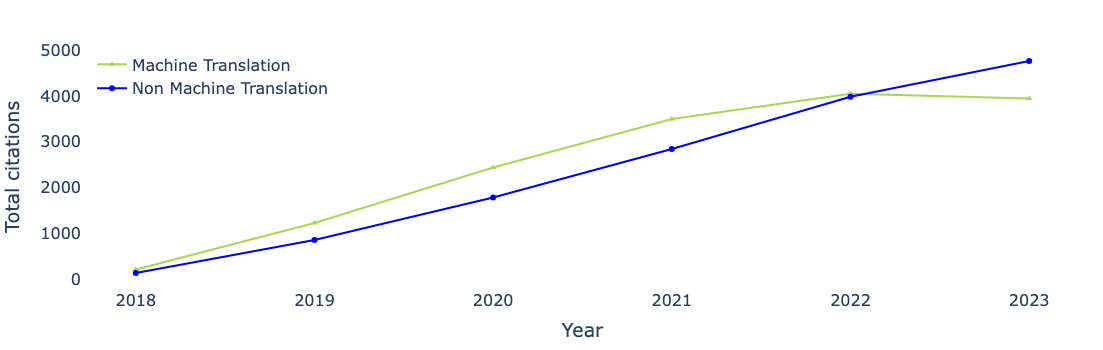

In [147]:
import plotly.graph_objects as go
import pandas as pd

mt = 'Machine Translation'
years = [2018, 2019, 2020, 2021, 2022, 2023]
data_mt = pd.DataFrame({'MT': [mt_citation_counts.get(year, 0) for year in years]}, index=years)
data_non_mt = pd.DataFrame({'Non-MT': [non_mt_citation_counts.get(year, 0) for year in years]}, index=years)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_mt.index,
    y=data_mt['MT'],
    mode='lines+markers',
    name=mt,
    marker=dict(color=track_styles[mt]['color'], symbol=track_styles[mt]['marker']),
    line=dict(color=track_styles[mt]['color'])
))

fig.add_trace(go.Scatter(
    x=data_non_mt.index,
    y=data_non_mt['Non-MT'],
    mode='lines+markers',
    name='Non ' + mt,
    marker=dict(color='blue', symbol='circle'),
    line=dict(color='blue')
))

fig.update_layout(
    xaxis=dict(
        title='Year',
        tickmode='array',
        tickvals=years,
        type='category'
    ),
    yaxis=dict(
        title='Total citations'
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='rgba(0,0,0,0.1)'
    ),
    plot_bgcolor='white',
    margin=dict(l=20, r=20, t=45, b=20),
    width=500,
    height=350,
    font=dict(size=16)
)

fig.show()


## How much are non interpretability papers actually citing interpretability?

In [149]:
non_interp_citation_distribution = { year: [] for year in years }

for node in tqdm(G.nodes()):
    # check that the node is an interp paper from our dataset
    if G.nodes[node]['originally_from_dataset'] is not True:
        continue
    track = raw_track_to_track(G.nodes[node]['area'])
    if track == 'Interpretability and Analysis' :
        continue

    
    references = G.in_edges(node)
    interp = 0
    non_interp = 0
    for reference, self in references:
        assert(self == node)
        # we still have papers with no prediction
        if 'interpretability_prediction' not in G.nodes[reference]:
            continue
        interp_citation = G.nodes[reference]['interpretability_prediction']
        if interp_citation is None:
            continue

        
        if interp_citation:
            interp += 1
        else:
            non_interp += 1
    
    total = interp + non_interp
    if total == 0:
        # some papers have no references according to semantic scholar
        # (they do have, but semantic scholar does not recognize them)
        continue
        
    interp_percentage = interp /(non_interp + interp) * 100
    year = G.nodes[node]['year']
    non_interp_citation_distribution[year].append(interp_percentage)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185384/185384 [00:00<00:00, 640779.83it/s]


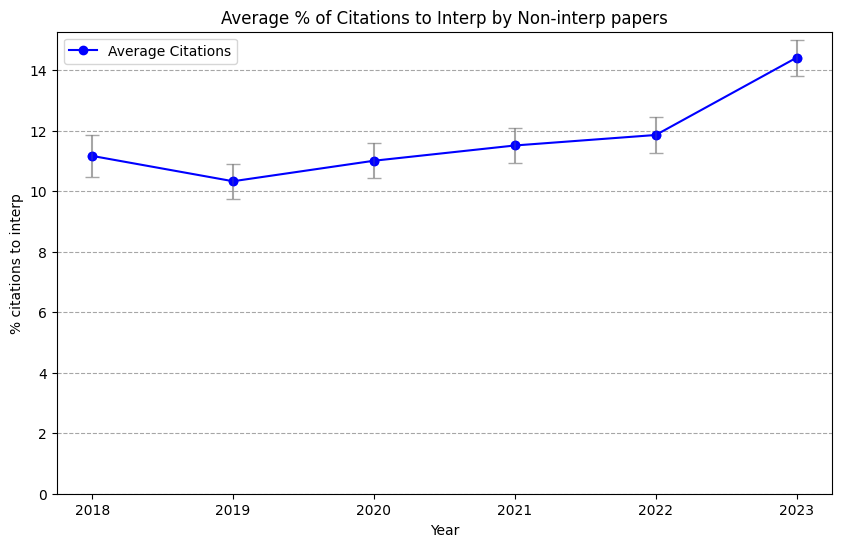

In [151]:
averages = [np.mean(non_interp_citation_distribution[year]) for year in years]
standard_errors = [np.std(non_interp_citation_distribution[year], ddof=1) / np.sqrt(len(non_interp_citation_distribution[year])) for year in years]

std_to_get_to_95_conf = 1.96
confidence_intervals = [std_to_get_to_95_conf * se for se in standard_errors]

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(years, averages, 'o-', color='blue', label='Average Citations')
ax.errorbar(years, averages, yerr=confidence_intervals, fmt='o', color='blue', ecolor='gray', alpha=0.7, capsize=5)

ax.set_xlabel('Year')
ax.set_ylabel('% citations to interp')
ax.set_title('Average % of Citations to Interp by Non-interp papers')
ax.set_ylim(bottom=0)

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.legend()
plt.show()

In [63]:
#### how does the previous plot compare to MT?
years = [2018, 2019, 2020, 2021, 2022, 2023]
non_mt_citation_distribution = { year: [] for year in years }

for node in tqdm(G.nodes()):
    # check that the node is an interp paper from our dataset
    if G.nodes[node]['originally_from_dataset'] is not True:
        continue
    track = raw_track_to_track(G.nodes[node]['area'])
    if track == 'Machine Translation' :
        continue

    
    references = G.in_edges(node)
    mt = 0
    non_mt = 0
    for reference, self in references:
        assert(self == node)
        # we still have papers with no prediction
        if 'mt_prediction' not in G.nodes[reference]:
            continue
        mt_citation = G.nodes[reference]['mt_prediction']
        if mt_citation is None:
            continue

        
        if mt_citation:
            mt += 1
        else:
            non_mt += 1
    
    total = mt + non_mt
    if total == 0:
        # some papers have no references according to semantic scholar
        # (they do have, but semantic scholar does not recognize them)
        continue
        
    mt_percentage = mt /(non_mt + mt) * 100
    year = G.nodes[node]['year']
    non_mt_citation_distribution[year].append(mt_percentage)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185384/185384 [00:00<00:00, 629000.72it/s]


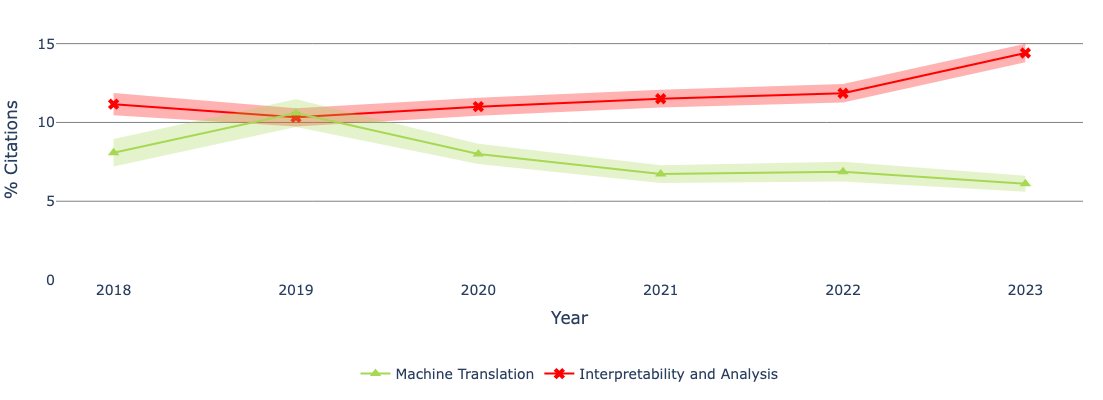

In [153]:
import plotly.graph_objects as go

# copied from https://community.plotly.com/t/scatter-plot-fill-with-color-how-to-set-opacity-of-fill/29591
def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip("#")
    if len(hex_color) == 3:
        hex_color = hex_color * 2
    return int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)


interp = 'Interpretability and Analysis'
mt = 'Machine Translation'
opacity=0.3

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=years,
    y=averages,
    mode='lines+markers',
    name=interp,
    line=dict(color=track_styles[interp]['color']),
    marker=dict(color=track_styles[interp]['color'], symbol=track_styles[interp]['marker'], size=10)

))
fig.add_trace(go.Scatter(
    x=years,
    y=[y - e for y, e in zip(averages, confidence_intervals)],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor=f"rgba{(*hex_to_rgb(track_styles[interp]['color']), opacity)}",
))
fig.add_trace(go.Scatter(
    x=years,
    y=[y + e for y, e in zip(averages, confidence_intervals)],
    fill='tonexty',
    mode='lines',
    line=dict(width=0),
    fillcolor=f"rgba{(*hex_to_rgb(track_styles[interp]['color']), opacity)}",
    showlegend=False
))

averages_mt = [np.mean(non_mt_citation_distribution[year]) for year in years]
standard_errors_mt = [np.std(non_mt_citation_distribution[year], ddof=1) / np.sqrt(len(non_mt_citation_distribution[year])) for year in years]
confidence_intervals_mt = [1.96 * se for se in standard_errors_mt]

fig.add_trace(go.Scatter(
    x=years,
    y=averages_mt,
    mode='lines+markers',
    name=mt,
     line=dict(color=track_styles[mt]['color']),
    marker=dict(color=track_styles[mt]['color'], symbol=track_styles[mt]['marker'], size=10)
))
fig.add_trace(go.Scatter(
    x=years,
    y=[y - e for y, e in zip(averages_mt, confidence_intervals_mt)],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor=f"rgba{(*hex_to_rgb(track_styles[mt]['color']), opacity)}"
))
fig.add_trace(go.Scatter(
    x=years,
    y=[y + e for y, e in zip(averages_mt, confidence_intervals_mt)],
    fill='tonexty',
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor=f"rgba{(*hex_to_rgb(track_styles[mt]['color']), opacity)}"
))

fig.update_layout(
    xaxis=dict(title='Year', tickmode='array', tickvals=years, type='category'),
    yaxis=dict(title='% Citations', range=[0, max(max([y + e for y, e in zip(averages, confidence_intervals)]), max([y + e for y, e in zip(averages_mt, confidence_intervals_mt)]))*1.1]),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=400,
    width=500,
    margin=dict(l=20, t=20, r=20, b=10),
    legend=dict(
        x=0.5,
        y=-0.3,
        xanchor='center',
        yanchor='top',
        orientation='h'
    ),
    font=dict(size=14)
)

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')

fig.show()


## Which tracks cite interpretability the most (outside of interp)?

In [154]:
years = [2018, 2019, 2020,2021, 2022, 2023]
citation_distribution_by_track = { track: {year: [] for year in years} for track in tracks }

for node in tqdm(G.nodes()):
    # check that the node is an interp paper from our dataset
    if G.nodes[node]['originally_from_dataset'] is not True:
        continue
    track = raw_track_to_track(G.nodes[node]['area'])
    if track == 'Interpretability and Analysis' or track is None:
        continue

    
    references = G.in_edges(node)
    interp = 0
    non_interp = 0
    for reference, self in references:
        assert(self == node)
        # we still have papers with no prediction
        if 'interpretability_prediction' not in G.nodes[reference]:
            continue
        interp_citation = G.nodes[reference]['interpretability_prediction']
        if interp_citation is None:
            continue

        
        if interp_citation:
            interp += 1
        else:
            non_interp += 1
    
    total = interp + non_interp
    if total == 0:
        # some papers have no references according to semantic scholar
        # (they do have, but semantic scholar does not recognize them)
        continue
        
    interp_percentage = interp /(non_interp + interp) * 100
    year = G.nodes[node]['year']
    citation_distribution_by_track[track][year].append(interp_percentage)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185384/185384 [00:00<00:00, 491558.68it/s]


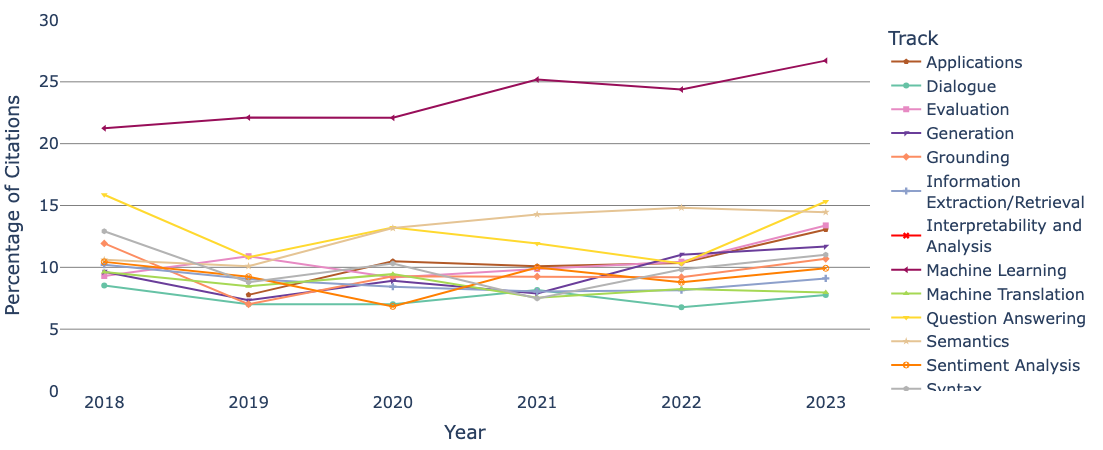

In [158]:
import scipy.stats as stats
conf_interval = 0.95

fig = go.Figure()
for track in tracks:
    mean_citations = []

    for year in years:
        data = citation_distribution_by_track[track][year]
        mean_val = np.mean(data)
        mean_citations.append(mean_val)
  
    fig.add_trace(go.Scatter(
        x=years,
        y=mean_citations,
        mode='lines+markers',
        name=track_to_pretty_name(track),
        line=dict(color=track_styles[track]['color']),
        marker=dict(symbol=track_styles[track]['marker'])
    ))

fig.update_layout(
    xaxis=dict(
        title='Year',
        tickmode='array',
        tickvals=years,
        type='category'
    ),
    yaxis=dict(
        title='Percentage of Citations',
        range=[0, 30]
    ),
    legend_title='Track',
    plot_bgcolor='white',
    height=450,
    width=750,
    font=dict(size=16),
    margin=dict(l=20, t=20, r=20, b=10),
)

fig.update_yaxes(showgrid=True, gridcolor='gray', gridwidth=1)

fig.show()

## How does the distribution of % of cited papers corresponding interp look like?

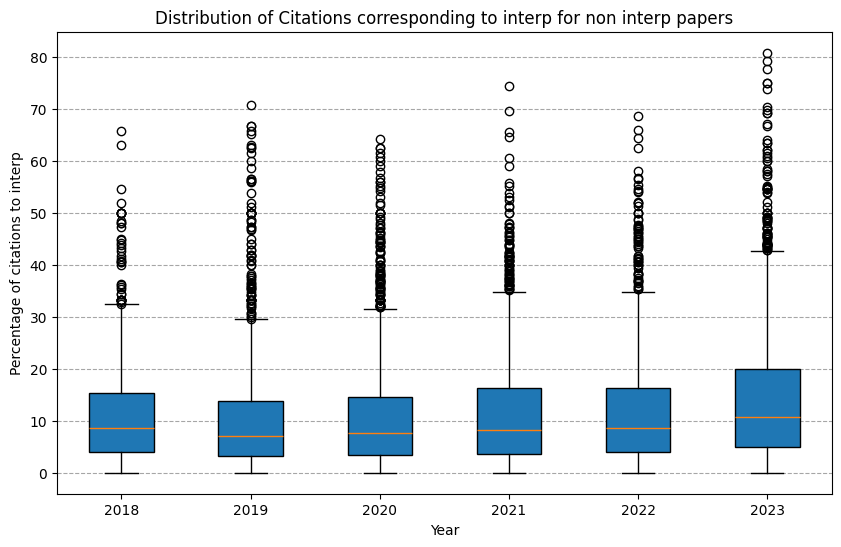

In [78]:
data_to_plot = [non_interp_citation_distribution[year] for year in years]

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data_to_plot, labels=years, patch_artist=True)

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of citations to interp')
ax.set_title('Distribution of Citations corresponding to interp for non interp papers')

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.set_axisbelow(True)

plt.show()

## Are interpretability/analysis citations influential?

In [159]:
tracks = list(set(post_2020_df['track'].dropna()))
years = [2020, 2021, 2022, 2023] # years in which the interp track actually exists


citations = { track: defaultdict(int) for track in tracks }
non_citations = { track: defaultdict(int) for track in tracks }

for cited_node, citing_node in tqdm(G.edges()):
    citing_year = G.nodes[citing_node]['year']
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track is None:
        continue
    

    citation_info = G.get_edge_data(cited_node, citing_node)
    if citation_info['is_influential']:
        citations[track][cited_year] += 1
    else:
        non_citations[track][cited_year] += 1



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 848446.47it/s]


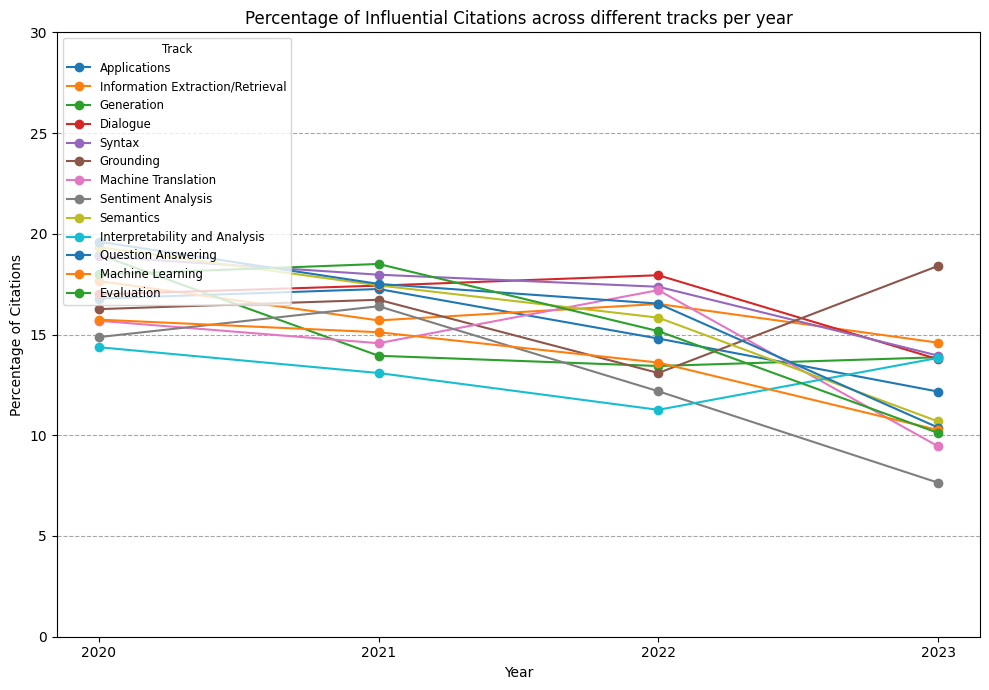

In [160]:

conf_interval = 0.95
fig, ax = plt.subplots(figsize=(10, 7))

for track in tracks:
    percentages = []
    ci_lower = []
    ci_upper = []
    
    for year in years:
        total = citations[track][year] + non_citations[track][year]
        if total == 0:
            continue
        percentage = (citations[track][year] / total) * 100
        percentages.append(percentage)
        
        standard_error = np.sqrt((percentage * (100 - percentage)) / total)
        ci = stats.norm.interval(conf_interval, loc=percentage, scale=standard_error)
        ci_lower.append(ci[0])
        ci_upper.append(ci[1])
    
    ax.plot(years, percentages, 'o-', label=track)
    #ax.fill_between(years, ci_lower, ci_upper, alpha=0.15)

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Citations')
ax.set_ylim(bottom=0, top=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.legend(title='Track', loc='upper left', fontsize='small', title_fontsize='small')
plt.title('Percentage of Influential Citations across different tracks per year')
plt.tight_layout()
plt.show()


## Are citations of interpretability outside of its area more influential than other tracks?

In [161]:
influential_interp =  defaultdict(int)
non_influential_interp =  defaultdict(int)

for cited_node, citing_node in tqdm(G.edges()):
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Interpretability and Analysis':
        continue

    if 'interpretability_prediction' not in G.nodes[cited_node]:
        continue
    interp = G.nodes[cited_node]['interpretability_prediction']
    if interp is None or interp is True:
        continue
    assert(interp is False)

    
    citation_info = G.get_edge_data(cited_node, citing_node)
    if citation_info['is_influential']:
        influential_interp[cited_year] += 1
    else:
        non_influential_interp[cited_year] += 1

influential_interp, non_influential_interp

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 1650666.96it/s]


(defaultdict(int, {2020: 46, 2021: 14, 2022: 56, 2023: 40}),
 defaultdict(int, {2020: 390, 2021: 102, 2022: 293, 2023: 268}))

In [162]:
influential_mt =  defaultdict(int)
non_influential_mt =  defaultdict(int)

for cited_node, citing_node in tqdm(G.edges()):
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Machine Translation':
        continue

    if 'mt_prediction' not in G.nodes[cited_node]:
        continue
    interp = G.nodes[cited_node]['mt_prediction']
    if interp is None or interp is True:
        continue
    assert(interp is False)

    
    citation_info = G.get_edge_data(cited_node, citing_node)
    if citation_info['is_influential']:
        influential_mt[cited_year] += 1
    else:
        non_influential_mt[cited_year] += 1

influential_mt, non_influential_mt

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 1646250.95it/s]


(defaultdict(int, {2020: 104, 2021: 4, 2022: 51, 2018: 37, 2019: 5, 2023: 2}),
 defaultdict(int,
             {2020: 458, 2021: 46, 2022: 266, 2023: 11, 2018: 246, 2019: 74}))

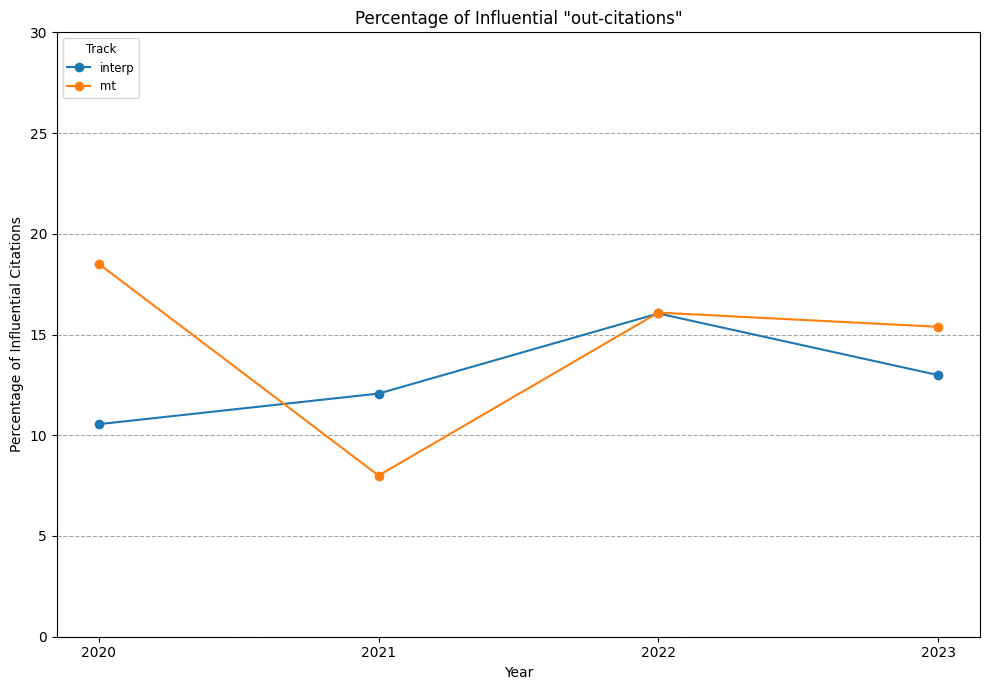

In [163]:

fig, ax = plt.subplots(figsize=(10, 7))

interp_percentages = []
for year in years:
    total = influential_interp[year] + non_influential_interp[year]
    if total == 0:
        continue
    percentage = (influential_interp[year] / total) * 100
    interp_percentages.append(percentage)
ax.plot(years, interp_percentages, 'o-', label='interp')
    
mt_percentages = []
for year in years:
    total = influential_mt[year] + non_influential_mt[year]
    if total == 0:
        continue
    percentage = (influential_mt[year] / total) * 100
    mt_percentages.append(percentage)
ax.plot(years, mt_percentages, 'o-', label='mt')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Influential Citations')
ax.set_ylim(bottom=0, top=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.legend(title='Track', loc='upper left', fontsize='small', title_fontsize='small')
plt.title('Percentage of Influential "out-citations"')
plt.tight_layout()
plt.show()


## Where is interpretability being cited?

In [164]:
years = [2020, 2021, 2022, 2023]
metrics = ['background', 'result', 'methodology']

citations = { track: { year: { metric: {True: 0, False: 0} for metric in metrics } for year in years } for track in tracks }

for cited_node, citing_node in tqdm(G.edges()):
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    year = G.nodes[cited_node]['year']
    if year not in years:
        continue
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track is None:
        continue
    

    citation_info = G.get_edge_data(cited_node, citing_node)
    for metric in metrics:
        value = citation_info[metric]
        citations[track][year][metric][value] += 1
    

citations

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 1630960.71it/s]


{'Applications': {2020: {'background': {True: 2759, False: 2823},
   'result': {True: 171, False: 5411},
   'methodology': {True: 2152, False: 3430}},
  2021: {'background': {True: 1659, False: 1690},
   'result': {True: 98, False: 3251},
   'methodology': {True: 1306, False: 2043}},
  2022: {'background': {True: 1234, False: 1124},
   'result': {True: 54, False: 2304},
   'methodology': {True: 784, False: 1574}},
  2023: {'background': {True: 583, False: 436},
   'result': {True: 23, False: 996},
   'methodology': {True: 336, False: 683}}},
 'Information Extraction/Retrieval': {2020: {'background': {True: 4664,
    False: 5196},
   'result': {True: 296, False: 9564},
   'methodology': {True: 4048, False: 5812}},
  2021: {'background': {True: 2884, False: 3135},
   'result': {True: 165, False: 5854},
   'methodology': {True: 2241, False: 3778}},
  2022: {'background': {True: 1240, False: 1442},
   'result': {True: 88, False: 2594},
   'methodology': {True: 1074, False: 1608}},
  2023: 

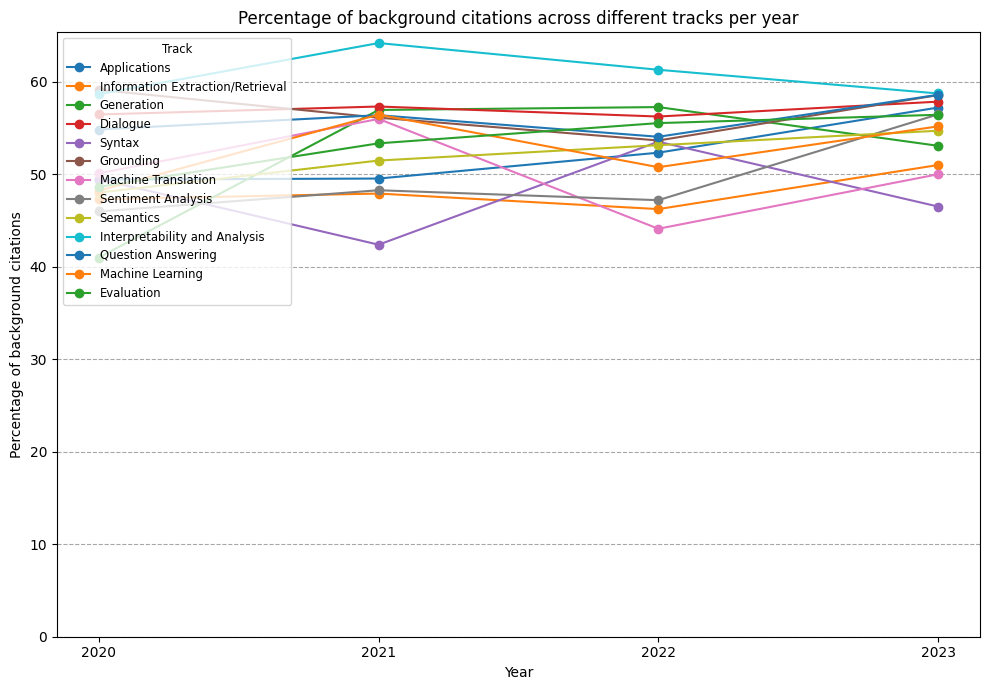

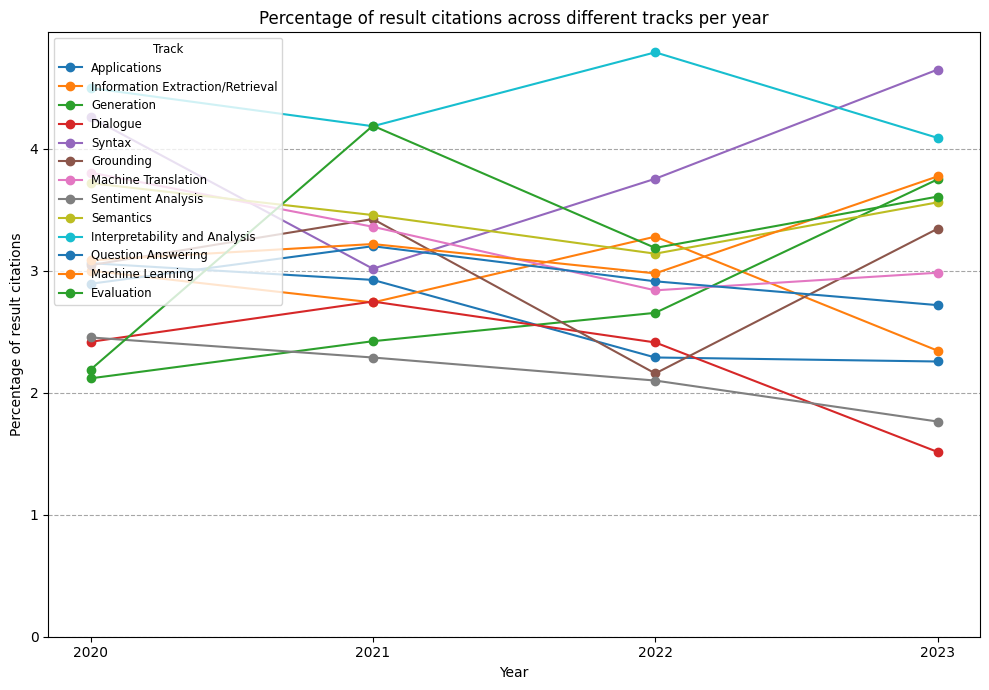

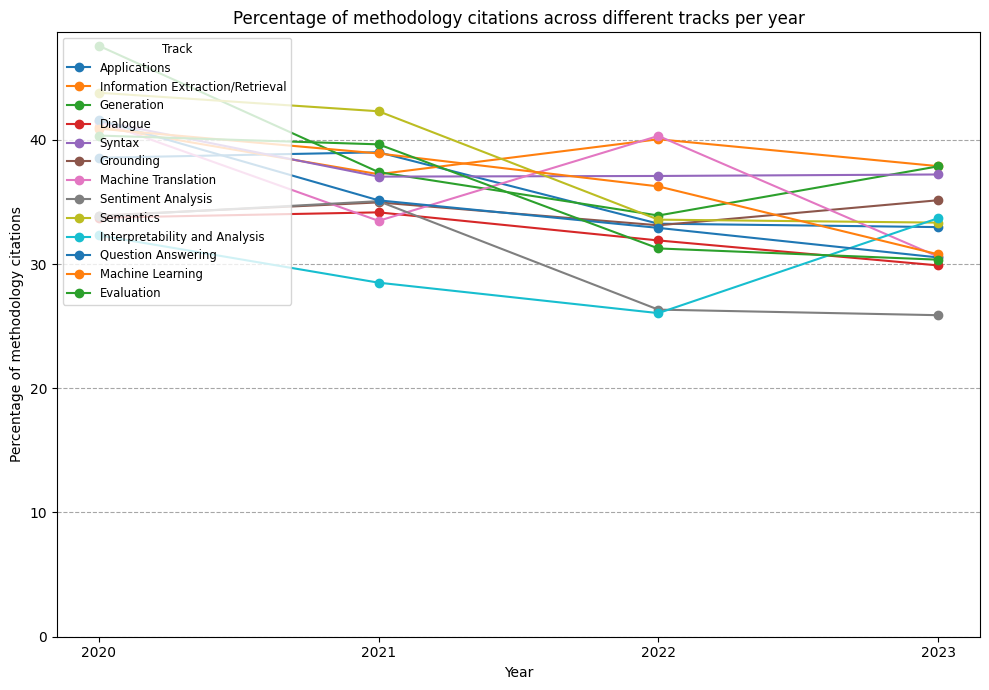

In [165]:
conf_interval = 0.95

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 7))
    for track in tracks:
        percentages = []

        for year in years:
            data = citations[track][year][metric]
            total = sum(data.values())
            if total == 0:
                continue
            percentage = (data[True] / total) * 100
            percentages.append(percentage)

        ax.plot(years, percentages, 'o-', label=track)

    ax.set_xlabel('Year')
    ax.set_ylabel(f'Percentage of {metric} citations')
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
    ax.legend(title='Track', loc='upper left', fontsize='small', title_fontsize='small')
    plt.title(f'Percentage of {metric} citations across different tracks per year')
    plt.tight_layout()
    plt.show()

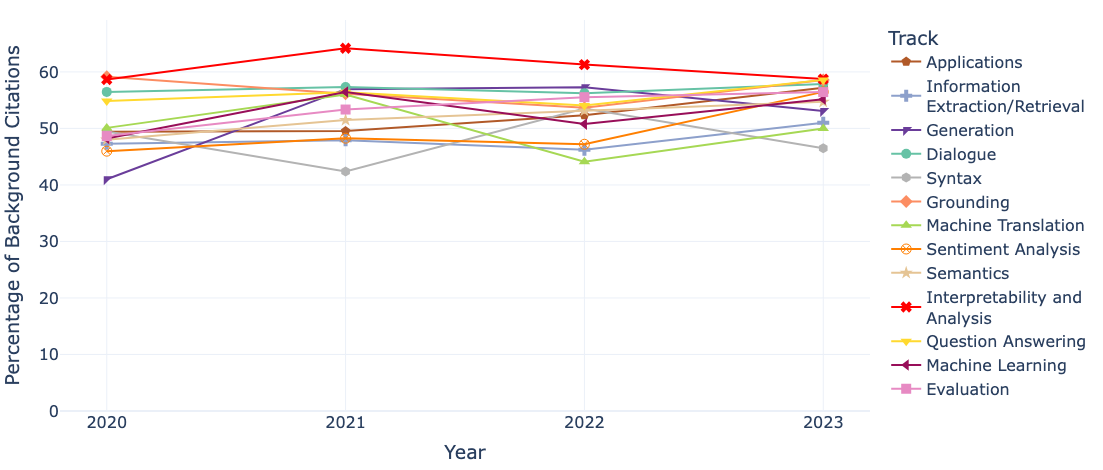

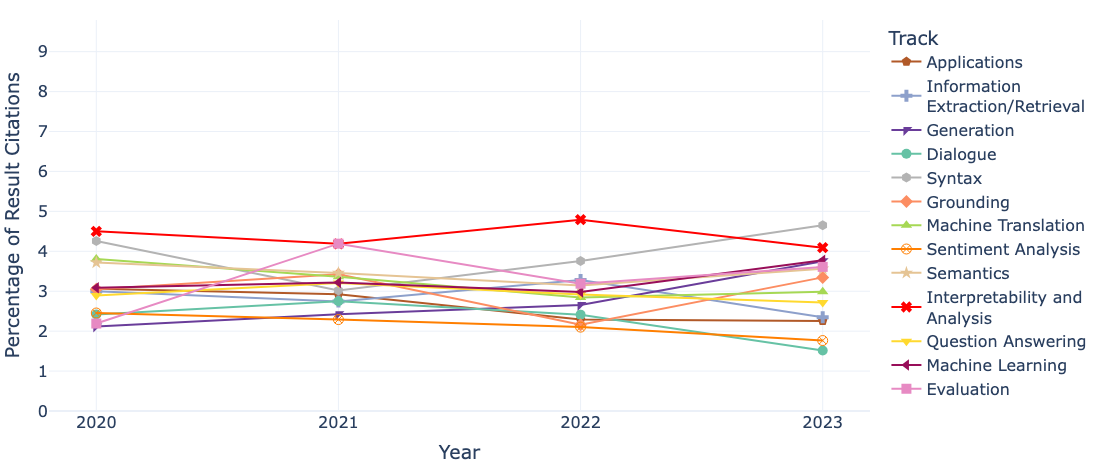

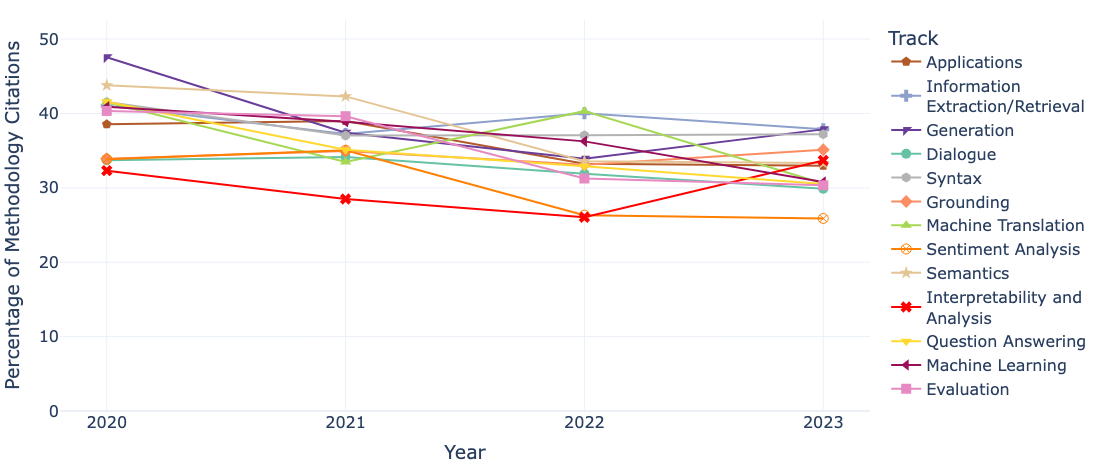

In [167]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats


for metric in metrics:
    fig = go.Figure()
    max_percentage = 0
    for track in tracks:
        percentages = []

        for year in years:
            data = citations[track][year][metric]
            total = sum(data.values())
            if total == 0:
                continue
            percentage = (data[True] / total) * 100
            percentages.append(percentage)

        max_percentage = max(max_percentage, max(percentages))
        fig.add_trace(
            go.Scatter(x=years, y=percentages, mode='lines+markers', name=track_to_pretty_name(track),
                       line=dict(color=track_styles[track]['color']),
                       marker=dict(symbol=track_styles[track]['marker'], size=10))
        )

    y_axis_top = max_percentage + 5

    fig.update_layout(
        xaxis=dict(title='Year', tickmode='array', tickvals=years),
        yaxis=dict(title=f'Percentage of {metric.capitalize()} Citations', range=[0, y_axis_top]),
        legend_title='Track',
        font=dict(size=16),
        height=470,
        width=600,
        template='plotly_white',
        margin=dict(l=20, t=20, r=20, b=10),
    )
    
    fig.show()


# Citation literature metrics

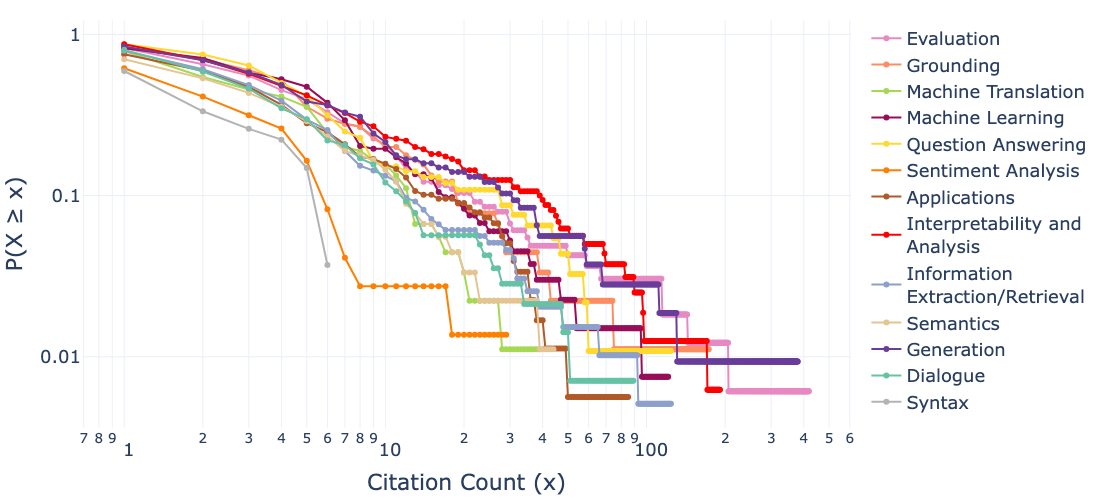

In [168]:
import plotly.graph_objects as go

year = 2023
citation_counts_by_track = {}
for node in G.nodes():
    paper = G.nodes[node]
    if paper['originally_from_dataset'] is not True or paper['year'] != year:
        continue
    track = raw_track_to_track(paper['area'])
    if track is None:
        continue
    if track not in citation_counts_by_track:
        citation_counts_by_track[track] = []
    citation_counts_by_track[track].append(paper['citation_count'])

fig = go.Figure()

for track, counts in citation_counts_by_track.items():

    max_citation = max(counts)
    cumulative_distribution = [sum(count >= x for count in counts) / len(counts) for x in range(1, max_citation + 1)]
    fig.add_trace(go.Scatter(
        x=list(range(1, max_citation + 1)),
        y=cumulative_distribution,
        mode='lines+markers',
        name=track_to_pretty_name(track),
        line=dict(color=track_styles[track]['color']),
     ) 
    )

fig.update_layout(
    xaxis_title='Citation Count (x)',
    yaxis_title='P(X ≥ x)',
    xaxis_type='log',
    yaxis_type='log',
    height=500,
    width=900,
    font=dict(size=18),
    yaxis=dict(
        type='log',
        tickmode='array',
        tickvals=[10**(-i) for i in range(6)],
        showgrid=True,
    ),
    template='plotly_white',
    margin=dict(l=20, t=20, r=20, b=10),
)

fig.show()


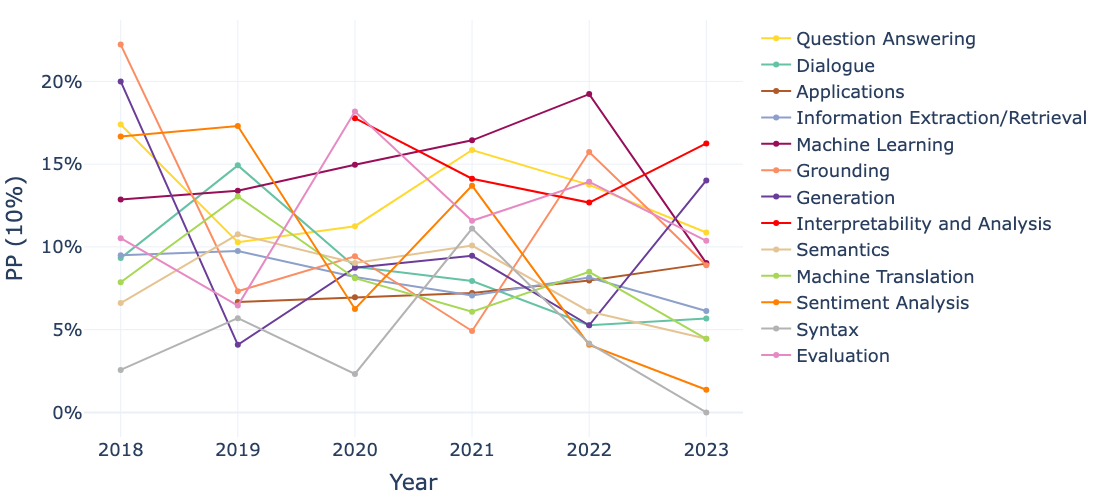

In [100]:
import plotly.graph_objects as go
from numpy import percentile

citation_counts_by_year = {}
citation_counts_by_year_area = {}
percentile_90_by_year = {}

for node in G.nodes():
    paper = G.nodes[node]
    if paper['originally_from_dataset']:
        year = paper['year']
        area = raw_track_to_track(paper['area']) if paper['area'] else None
        if year not in citation_counts_by_year:
            citation_counts_by_year[year] = []
        citation_counts_by_year[year].append(paper['citation_count'])
        if area is not None:
            if (year, area) not in citation_counts_by_year_area:
                citation_counts_by_year_area[(year, area)] = []
            citation_counts_by_year_area[(year, area)].append(paper['citation_count'])

for year, citations in citation_counts_by_year.items():
    percentile_90_by_year[year] = percentile(citations, 90)

plot_data = {}
for (year, area), citations in citation_counts_by_year_area.items():
    above_threshold = sum(citation >= percentile_90_by_year[year] for citation in citations) / len(citations)
    if area not in plot_data:
        plot_data[area] = []
    plot_data[area].append((year, above_threshold * 100))

fig = go.Figure()
for area, data in plot_data.items():
    data_sorted = sorted(data)
    years, percentages = zip(*data_sorted)
    fig.add_trace(go.Scatter(
        x=years,
        y=percentages,
        mode='lines+markers',
        name=area,
        line=dict(color=track_styles[area]['color']),
        marker=dict(color=track_styles[area]['color'])
    ))

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='PP (10%)',
    xaxis=dict(type='category'),
    yaxis=dict(ticksuffix='%'),
    width=800,
    height=500,
    template='plotly_white',
    font=dict(size=18),
    margin=dict(l=20, t=20, r=20, b=10),
)

fig.show()


In [170]:
import numpy as np
from bisect import bisect_right, bisect_left

def calculate_csi(citations_A, citations_B):
    total_pairs = len(citations_A) * len(citations_B)
    count_more_cited = 0
    for citation_B in citations_B:
        more_cited = len(citations_A) - bisect_right(citations_A, citation_B)
        same_cited = bisect_right(citations_A, citation_B) - bisect_left(citations_A, citation_B)
        
        count_more_cited += more_cited + 0.5 * same_cited

    return count_more_cited / total_pairs

citations_track_A = [10, 20, 30, 40, 50]
citations_track_B = [5, 15, 25, 35]

calculate_csi(citations_track_A, citations_track_B)

0.7

In [171]:
set(df['track'])

{'Applications',
 'Dialogue',
 'Evaluation',
 'Generation',
 'Grounding',
 'Information Extraction/Retrieval',
 'Interpretability and Analysis',
 'Machine Learning',
 'Machine Translation',
 None,
 'Question Answering',
 'Semantics',
 'Sentiment Analysis',
 'Syntax'}

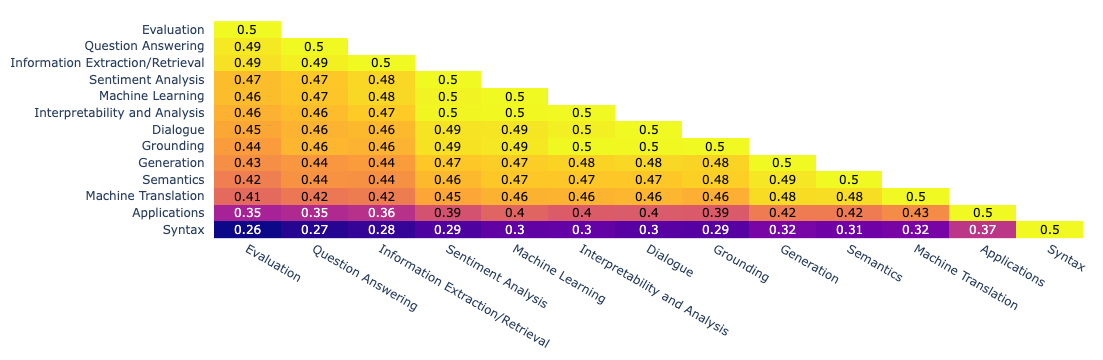

In [177]:
year = 2021
track_citations = {}
for node in G.nodes():
    paper = G.nodes[node]
    if paper['originally_from_dataset'] is not True:
        continue
    if paper['year'] != year:
        continue
    
    track = raw_track_to_track(paper['area'])
    citation_count = paper['citation_count']
    if track is not None:
        if track not in track_citations:
            track_citations[track] = []
        track_citations[track].append(citation_count)

for track in track_citations:
    track_citations[track].sort()



csi_matrix = []
tracks = ['Machine Learning', 'Grounding', 'Evaluation', 'Question Answering', 'Interpretability and Analysis', 'Semantics', 'Dialogue', 'Machine Translation', 'Information Extraction/Retrieval', 'Generation', 'Applications', 'Sentiment Analysis', 'Syntax']
track_to_mean_csi = {}
for track1 in tracks:
    row = []
    for track2 in tracks:
        csi_score = calculate_csi(track_citations[track1], track_citations[track2])
        row.append(csi_score)
    csi_matrix.append(row)
    mean_csi = sum(row) / len(row)
    track_to_mean_csi[track1] = mean_csi
tracks.sort(key=lambda track: -track_to_mean_csi[track])
csi_matrix = []

for track1 in tracks:
    row = []
    for track2 in tracks:
        csi_score = calculate_csi(track_citations[track1], track_citations[track2])
        row.append(csi_score)
    csi_matrix.append(row)
    mean_csi = sum(row) / len(row)
    track_to_mean_csi[track1] = mean_csi

mask = 1 - np.tril(np.ones_like(csi_matrix, dtype=bool))
csi_lower = np.where(mask, np.nan, csi_matrix)

annotation_text = [[f"{value:.2}" if not np.isnan(value) else "" for value in row] for row in csi_lower]

fig = ff.create_annotated_heatmap(
    z=csi_lower,
    x=tracks,
    y=tracks,
    annotation_text=annotation_text,
    colorscale='Plasma',
    zmin=np.nanmin(csi_lower) - 0.0,
    zmax=np.nanmax(csi_lower) 
    
)
fig.update_layout(
    xaxis=dict(side='bottom', showgrid=False),
    yaxis=dict(autorange='reversed', showgrid=False),
    margin=dict(l=20, t=20, r=20, b=10),
    template='plotly_white',
    
)
fig.show()